In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import tarfile
from discretize import TensorMesh, TreeMesh
from discretize.utils import active_from_xyz
from simpeg.potential_fields import magnetics
from simpeg.utils import plot2Ddata, model_builder, download
from simpeg import (maps, data, data_misfit, inverse_problem, regularization, optimization, directives, inversion,)
mpl.rcParams.update({"font.size": 14})
import pyvista as pv

##### (1) Defining Input Data Location

In [3]:
output_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data"
boundary_loc = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Boundary4_Wajra_For_Magnetic_Inversion.bln"  # Use Boundary1 for residual study

In [4]:
topo_filename = output_dir + r"\SimPEG_Input\magnetics_topo_100m.txt"
data_filename = output_dir + r"\SimPEG_Input\magnetics_data_100m.obs"

In [5]:
# Load topography (xyz file)
topo_xyz = np.loadtxt(str(topo_filename))

# Load field data (xyz file)
dobs = np.loadtxt(str(data_filename))

###### (1A) Loading Localized Boundary within which Magnetic Inversion will be run

In [7]:
with open(boundary_loc, 'r') as f:
    lines = f.readlines()

boundary_coords = []
for line in lines:
    parts = line.replace(',', ' ').split()
    nums = [float(p) for p in parts]
    boundary_coords.append(nums)

boundary_coords = np.array(boundary_coords)

In [8]:
boundary_polygon = Polygon(boundary_coords)

###### (1B) Clipping data inside the Polygon

In [10]:
topo_xyz

array([[7.24646098e+05, 1.53911146e+06, 6.71200000e+02],
       [7.72203206e+05, 1.68720062e+06, 4.14600000e+02],
       [7.57578565e+05, 1.73706228e+06, 3.87100000e+02],
       ...,
       [6.81387903e+05, 1.56371140e+06, 6.10600000e+02],
       [6.90263838e+05, 1.55096016e+06, 5.94100000e+02],
       [7.61855767e+05, 1.65733018e+06, 3.90100000e+02]])

In [11]:
inside_topo = np.array([boundary_polygon.contains(Point(x, y)) for x, y, z in topo_xyz])
topo_xyz_clipped = topo_xyz[inside_topo]

In [12]:
inside_dobs = np.array([boundary_polygon.contains(Point(x, y)) for x, y, *_ in dobs])
dobs_clipped = dobs[inside_dobs]

In [13]:
# Define receiver locations and observed data
receiver_locations = dobs_clipped[:, 0:3]
dobs = dobs_clipped[:, -1]

##### (2) Plotting Polygon 

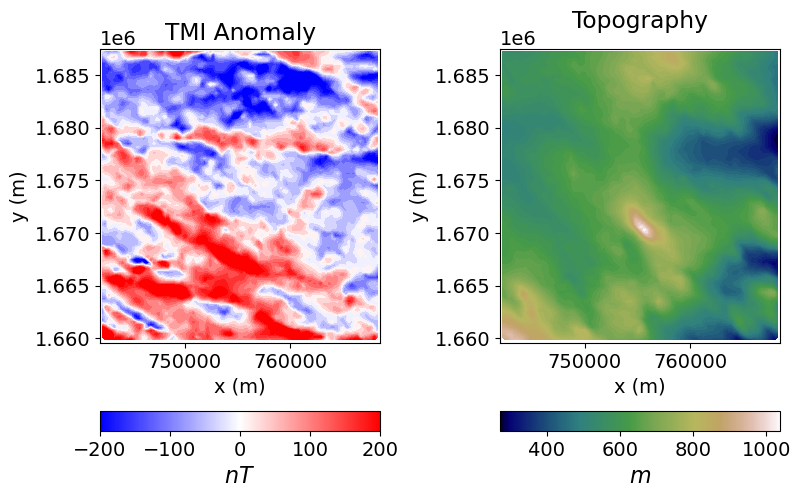

In [15]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])

v_max = np.max(np.abs(dobs))
norm1 = mpl.colors.Normalize(vmin=-200, vmax=200)

plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    dataloc=False,
    ncontour=40,
    contourOpts={"cmap": mpl.cm.bwr, "norm": norm1}
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

cx1 = fig.add_axes([0.05, 0.18, 0.35, 0.04])
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm1, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$nT$", size=16)

ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    topo_xyz_clipped[:, 0:2],
    topo_xyz_clipped[:, -1],
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)
ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

cx2 = fig.add_axes([0.55, 0.18, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(topo_xyz[:, -1]), vmax=np.max(topo_xyz[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)
cbar2.set_label("$m$", size=16)
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\Maps\TMI Anomaly vs Topography for Wajrakarur-Boundary.png", dpi=400)
plt.show()

##### (3) Defining uncertainity

In [17]:
dobs.min(), dobs.max()

(-465.9218, 450.9862)

In [18]:
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.002 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))

Floor uncertainty: 0.9318436000000001


##### (4) Survey Definition

In [20]:
# Define the component(s) of the field we are inverting as a list. Here we will
# invert total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Define the inducing field
inclination = 33.5  # inclination [deg]
declination = 0.3  # declination [deg]
amplitude = 43800   # amplitude [nT]        #orignally it was 43800

source_field = magnetics.sources.UniformBackgroundField(
    receiver_list=receiver_list,
    amplitude=amplitude,
    inclination=inclination,
    declination=declination,
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

In [21]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

##### (5) Designing Mesh

In [23]:
x_min, x_max = topo_xyz_clipped[:,0].min(), topo_xyz_clipped[:,0].max()
y_min, y_max = topo_xyz_clipped[:,1].min(), topo_xyz_clipped[:,1].max()
z_min, z_max = topo_xyz_clipped[:,2].min(), topo_xyz_clipped[:,2].max()

print(f"X Range: {x_min:.0f} to {x_max:.0f}")
print(f"Y Range: {y_min:.0f} to {y_max:.0f}")
print(f"Z Range (elevation): {z_min:.0f} to {z_max:.0f}")

X Range: 741948 to 768524
Y Range: 1659564 to 1687502
Z Range (elevation): 382 to 529


In [153]:
# Generate tensor mesh with top at z = 0 m
dh = 250  # minimum cell size
dz = 250
npad = 1
hx = [(dh, npad, -1.3), (dh, 105), (dh, npad, 1.3)]  # discretization along x
hy = [(dh, npad, -1.3), (dh, 115), (dh, npad, 1.3)]   # discretization along y
hz = [(dz, 1, -1.3), (dz, 22)]                   # discretization along z

In [163]:
origin_x = topo_xyz_clipped[:,0].min() - npad * dh
origin_y = topo_xyz_clipped[:,1].min() - npad * dh
origin_z = -5000                                    #topo_xyz_clipped[:,2].max() + npad * dz

In [165]:
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

In [167]:
tensor_mesh.origin = np.r_[origin_x, origin_y, origin_z]

In [169]:
tensor_mesh

TensorMesh: 287,937 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    107    741,698.25    768,598.25    250.00    325.00    1.30
   y    117  1,659,313.97  1,688,713.97    250.00    325.00    1.30
   z     23     -5,000.00        825.00    250.00    325.00    1.30

##### (6) Active Cell Selection

In [172]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)
n_tensor_active = int(active_tensor_cells.sum())

In [173]:
n_tensor_active

268281

##### (7) Mapping Active Cells

In [175]:
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)

##### (8) Reference Model (A-Priori Model)

In [177]:
starting_tensor_model =  0.002 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [180]:
# Mapping to ignore inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

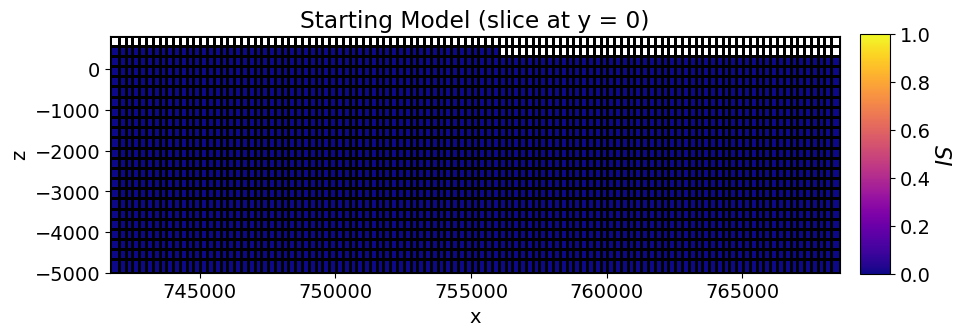

In [44]:
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
yind = 0
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind = yind,    #int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)
ax1.set_aspect(1.5)
ax2.set_aspect(8)
plt.savefig(rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\Initial Model at y = {yind}  with gridsize_{dh,dh,dz}m.png",dpi=200)
plt.show()

In [45]:
simulation_L2 = magnetics.simulation.Simulation3DIntegral(survey=survey, mesh=tensor_mesh, model_type="scalar",
    chiMap=tensor_model_map, ind_active=active_tensor_cells, engine="choclo",)

In [46]:
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)

In [47]:
reg_L2 = regularization.WeightedLeastSquares(tensor_mesh, active_cells=active_tensor_cells, length_scale_x=1.0, length_scale_y=1.0,
    length_scale_z=1.0, reference_model=reference_tensor_model, reference_model_in_smooth=False,)

In [48]:
opt_L2 = optimization.ProjectedGNCG(
    maxIter=100, lower=0.0, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

In [49]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [50]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

In [77]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.24.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


C:\Users\Kunal\anaconda3\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.40e+02  4.71e+07  8.32e+04  7.54e+07    2.52e+07      0              
   1  1.70e+02  3.56e+07  1.38e+04  3.80e+07    7.13e+07      0              
   2  8.50e+01  2.68e+07  4.84e+04  3.09e+07    5.08e+07      0              
   3  4.25e+01  1.92e+07  1.11e+05  2.39e+07    3.66e+07      0   Skip BFGS  
   4  2.12e+01  1.28e+07  2.18e+05  1.74e+07    2.66e+07      0   Skip BFGS  
   5  1.06e+01  7.95e+06  3.77e+05  1.20e+07    1.81e+07      0   Skip BFGS  
   6  5.31e+00  4.67e+06  5.89e+05  7.80e+06    1.18e+07      0   Skip BFGS  
   7  2.66e+00  2.58e+06  8.55e+05  4.85e+06    7.54e+06      0   Skip BFGS  
   8  1.33e+00  1.34e+06  1.17e+06  2.89e+06    4.34e+06      0   Skip BFGS  
   9  6.64e-01  6.63e+05

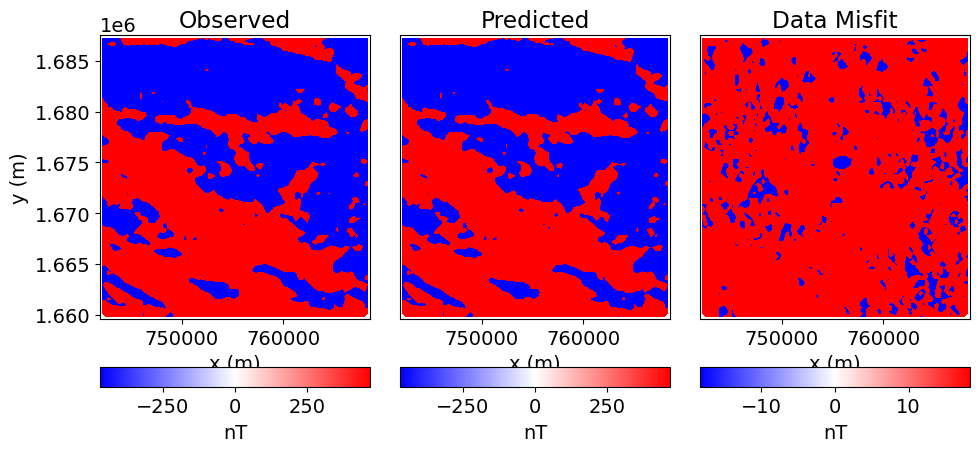

In [79]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs*1e9, dpred*1e9, (dobs - dpred)*1e9]

fig = plt.figure(figsize=(10, 4))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["nT", "nT", "nT"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]


for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], labelpad=5)
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\Data Misfit.png",dpi=200)
plt.show()

In [81]:
recovered_tensor_model.max(), dpred, tensor_plotting_map

(0.15741403765243173,
 array([ 220.05704 ,   58.204517,  106.44859 , ..., -116.37894 ,
         -58.092777,  -58.921722], dtype=float32),
 <simpeg.maps._injection.InjectActiveCells at 0x208423931d0>)

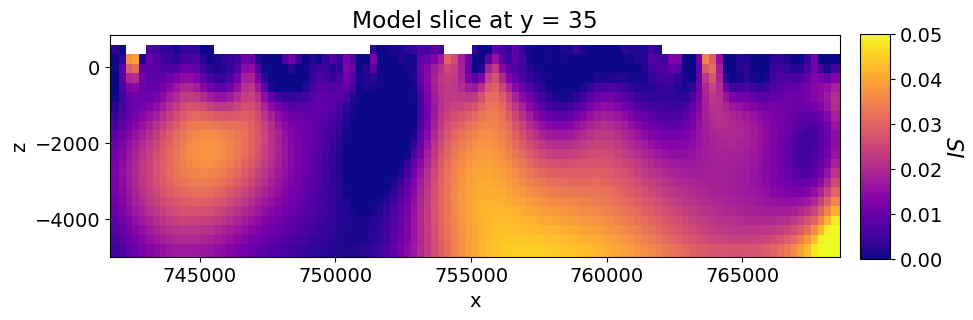

In [83]:
# Plot Recovered Model
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
yind = 35
norm = mpl.colors.Normalize(
    vmin=0, vmax=0.05
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=yind ,           #int(tensor_mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title(f"Model slice at y = {yind}")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)
ax1.set_aspect(1.4)
ax2.set_aspect(150)
plt.savefig(rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\Inverted Magnetic Susc Model Slice at {yind} Wajrakur Area.png",dpi=300)
plt.show()

In [139]:
for yind in range(0, tensor_mesh.shape_cells[1]):  # Loop from 0 to 116 inclusive
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
    
    norm = mpl.colors.Normalize(vmin=0, vmax=0.05)
    
    tensor_mesh.plot_slice(
        tensor_plotting_map * recovered_tensor_model,
        normal="Y",
        ax=ax1,
        ind=yind,
        grid=False,
        pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
    )
    ax1.set_title(f"Model slice at y = {yind}")
    
    ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
    cbar = mpl.colorbar.ColorbarBase(
        ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
    )
    cbar.set_label("$SI$", rotation=270, labelpad=15, size=16)
    ax1.set_aspect(1.4)
    ax2.set_aspect(150)
    
    output_path = rf"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\Inverted Magnetic Susc Model Slice at {yind} Wajrakur Area.png"
    plt.savefig(output_path, dpi=300)
    plt.close(fig)  # Close the figure to release memory


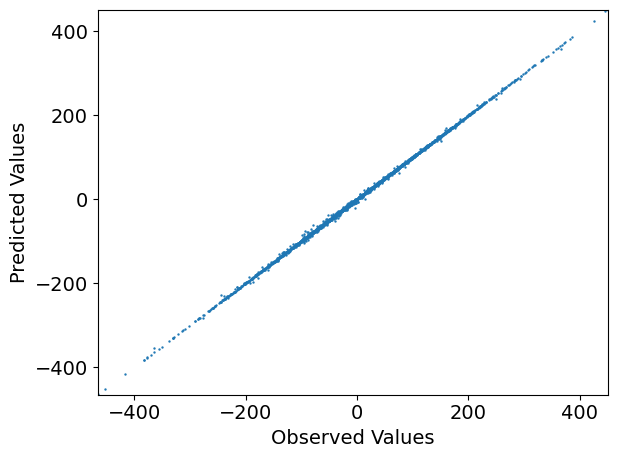

In [85]:
plt.scatter(dobs, dpred, s=0.5)
plt.xlim(dobs.min(),dobs.max())
plt.ylim(dobs.min(),dobs.max())
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\dobs-vs-dpred.png")
plt.show()

In [87]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties

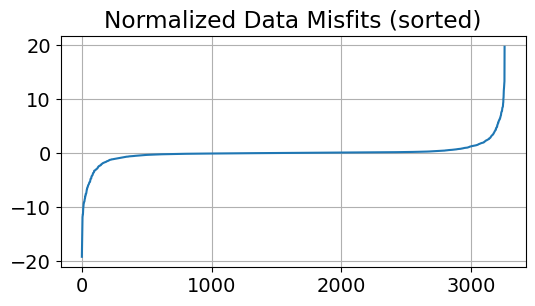

In [89]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data\SimPEG_Output\Wajrakur_Area\Normalized Data Misfits.png")
plt.show(fig)

In [422]:
# 1. Inject recovered model to full mesh (NaN in inactive)
model_3d = tensor_plotting_map * recovered_tensor_model

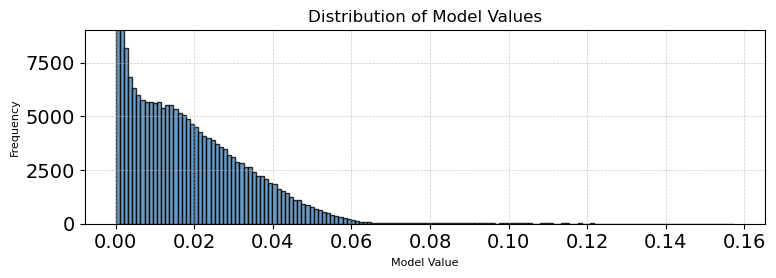

In [424]:
plt.figure(figsize=(8, 3))  
plt.hist(model_3d, bins=150, color='steelblue', edgecolor='black', alpha=0.8)
plt.title("Distribution of Model Values", fontsize=12)
plt.xlabel("Model Value", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.ylim(0,9000)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [562]:
# 2. Apply mask: only retain values between 0.05 and 0.1
model_masked = np.where((model_3d >= 0.00) & (model_3d <= 0.17), model_3d, np.nan)

# 3. Get voxel centers
x, y, z = tensor_mesh.cell_centers[:, 0], tensor_mesh.cell_centers[:, 1], tensor_mesh.cell_centers[:, 2]
values = model_masked

In [564]:
# 4. Filter only finite (non-NaN) voxels
mask = np.isfinite(values)
points = np.vstack([x[mask], y[mask], z[mask]]).T
values = values[mask]

In [566]:
# 5. Create point cloud for smooth rendering
cloud = pv.PolyData(points)
cloud['susceptibility'] = values

In [568]:
import pyvista as pv
pv.set_jupyter_backend('static')  

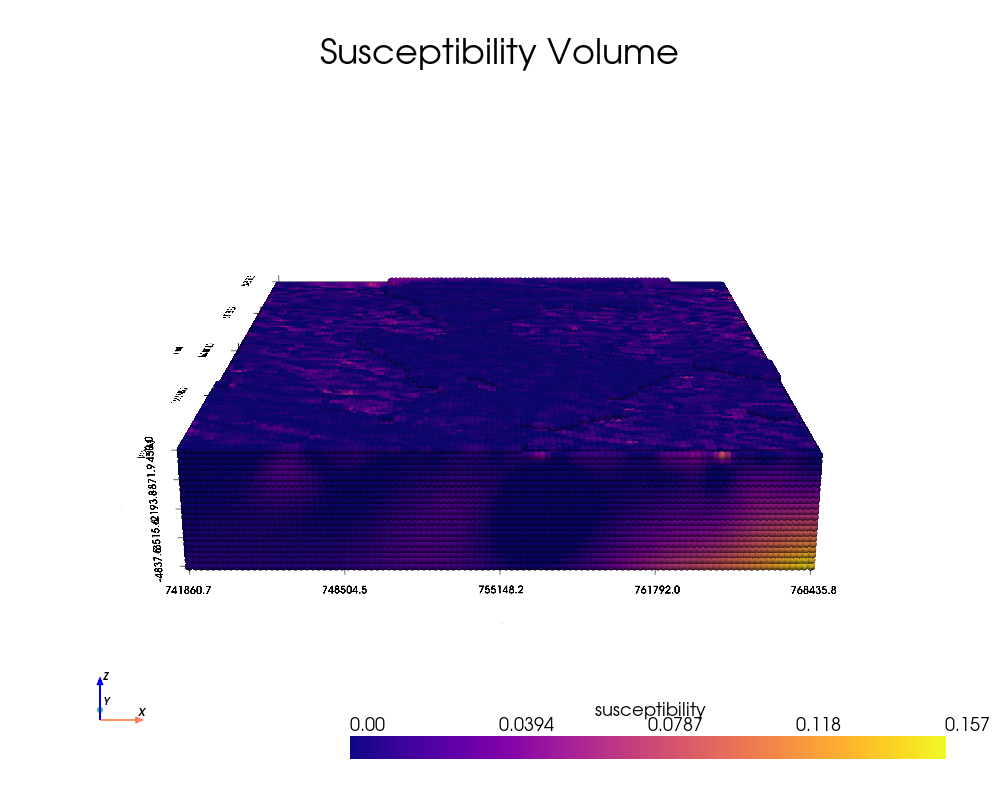

In [570]:
plotter = pv.Plotter(window_size=(1000, 800))      #window_size=(1000, 800)
plotter.add_mesh(cloud,
    scalars='susceptibility',
    cmap='plasma',
    render_points_as_spheres=True,
    point_size=9,
    nan_color='white'
)
plotter.add_axes()

plotter.show_bounds(
    grid='back',       # you can try 'all', 'front', 'back'
    location='outer',  # position of ticks
    all_edges=True,
    ticks='outside',
    xtitle='X [m]',
    ytitle='Y [m]',
    ztitle='Z [m]',
    color='black',
    font_size=8
)
plotter.add_title("Susceptibility Volume", font_size=14)
plotter.view_vector([0.00, -0.15, 0.05])
plotter.show()